In [913]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import seaborn as sns
sns.set(rc={'figure.figsize': (9, 6)})

In [914]:
class SGDClassifier(BaseEstimator):

    def __init__(self, eta=10**-3, max_iter=10, C=1, quiet=False):
        self.loss_ = []
        self.weights_ = []
        self.params = {}
        self.params['eta'] = eta
        self.params['max_iter'] = max_iter
        self.params['C'] = C
        self.params['quiet'] = quiet
        super(SGDClassifier, self).set_params(**self.params)
    
    def sigma(self, z):
        if z > 100:
            z = 100
        elif z < -100:
            z = -100
        return 1. / (1 + np.exp(-z))

    def fit(self, X, y):
        self.w = [0] * (len(X[0]) + 1)
#        self.w = np.random.randn(len(X[0]) + 1)

        for epoch in range(self.params['max_iter']):
            eta = self.params['eta']
#            eta = self.params['eta'] / (epoch + 1)
            for i in range(len(y)):
                y_pred = self.predict_dev(X[i])
                gradient = self.params['C'] * y[i] * self.sigma(-y[i] * y_pred)

                self.w[0] = self.w[0] + eta * (gradient - self.w[0])
                for j in range(len(X[i])):
                    self.w[j+1] = self.w[j+1] + eta * ((gradient * X[i][j]) - self.w[j+1])

            loss = log_loss(y, self.predict_proba(X))
            if len(self.loss_) > 0 and abs(loss - self.loss_[-1]) < 10**-6:
                break
            self.loss_.append(loss)
            self.weights_.append(self.w.copy())

            if not self.params['quiet']:
                print(f'>epoch={epoch}, log_loss={loss:.6f}')

        return self
        
    def predict_dev(self, X):
        pred = self.w[0]
        for i in range(len(X)):
            pred += self.w[i+1]*X[i]
        return pred

    def predict_proba(self, X):
        y_pred = []
        for i in range(len(X)):
            pred = self.predict_dev(X[i])
            c1 = self.sigma(pred)
            c0 = 1 - c1
            y_pred.append([c0, c1])
        return y_pred

    def predict(self, X):
        return [1 if i[0] < 0.5 else -1 for i in self.predict_proba(X)]

In [915]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [916]:
pd.Series(y).value_counts(normalize=True)*100

 1    62.741652
-1    37.258348
dtype: float64

In [917]:
sgd_clf = SGDClassifier(C=0.1, eta=10**-3, max_iter=3, quiet=True)
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(C=0.1, eta=0.001, max_iter=3, quiet=True)

In [918]:
print(f'train_score: {accuracy_score(y_train, sgd_clf.predict(X_train_scaled)), log_loss(y_train, sgd_clf.predict_proba(X_train_scaled))}')
print(f'valid_score: {accuracy_score(y_valid, sgd_clf.predict(X_valid_scaled)), log_loss(y_valid, sgd_clf.predict_proba(X_valid_scaled))}')

train_score: (0.9422110552763819, 0.5841773247989888)
valid_score: (0.9239766081871345, 0.5776882900285665)


In [919]:
pd.DataFrame({'w': pd.Series(sgd_clf.weights_[len(sgd_clf.weights_)-1][1:]).abs(),'name': cancer.feature_names}) \
    .set_index('name') \
    .sort_values(by=['w'], ascending=False)

,w
name,
worst concave points,0.023761
mean concave points,0.023088
worst perimeter,0.022855
worst radius,0.022560
mean perimeter,0.021253
worst area,0.020928
mean radius,0.020783
mean concavity,0.020657
worst concavity,0.020451


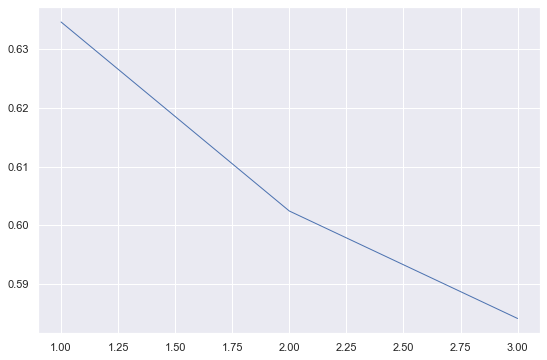

In [920]:
plt.plot(range(1, len(sgd_clf.loss_)+1), sgd_clf.loss_, linewidth=1);

In [921]:
sgd_clf = SGDClassifier(C=1, eta=10**-3, max_iter=20, quiet=False)
sgd_clf.fit(X_train_scaled, y_train)

>epoch=0, log_loss=0.393995
>epoch=1, log_loss=0.337472
>epoch=2, log_loss=0.318118
>epoch=3, log_loss=0.310196
>epoch=4, log_loss=0.306689
>epoch=5, log_loss=0.305065
>epoch=6, log_loss=0.304287
>epoch=7, log_loss=0.303903
>epoch=8, log_loss=0.303708
>epoch=9, log_loss=0.303607
>epoch=10, log_loss=0.303553
>epoch=11, log_loss=0.303524
>epoch=12, log_loss=0.303508
>epoch=13, log_loss=0.303499
>epoch=14, log_loss=0.303493
>epoch=15, log_loss=0.303490
>epoch=16, log_loss=0.303488
>epoch=17, log_loss=0.303487


SGDClassifier(C=1, eta=0.001, max_iter=20, quiet=False)

In [922]:
print(f'train_score: {accuracy_score(y_train, sgd_clf.predict(X_train_scaled)), log_loss(y_train, sgd_clf.predict_proba(X_train_scaled))}')
print(f'valid_score: {accuracy_score(y_valid, sgd_clf.predict(X_valid_scaled)), log_loss(y_valid, sgd_clf.predict_proba(X_valid_scaled))}')

train_score: (0.9522613065326633, 0.3034867355946027)
valid_score: (0.9473684210526315, 0.30445779561171654)


In [923]:
pd.DataFrame({'w': pd.Series(sgd_clf.weights_[len(sgd_clf.weights_)-1][1:]).abs(),'name': cancer.feature_names}) \
    .set_index('name') \
    .sort_values(by=['w'], ascending=False)

,w
name,
worst concave points,0.129160
worst radius,0.126563
worst perimeter,0.126362
mean concave points,0.121981
worst area,0.115942
mean perimeter,0.113526
mean radius,0.112154
worst concavity,0.108162
mean area,0.107766


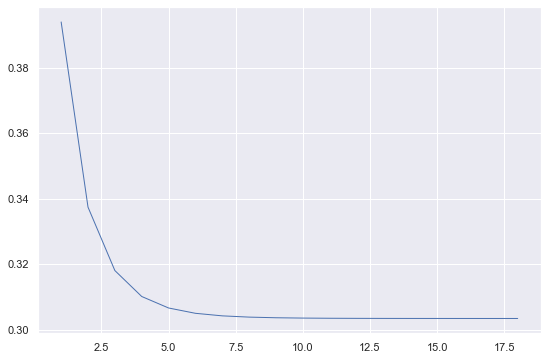

In [924]:
plt.plot(range(1, len(sgd_clf.loss_)+1), sgd_clf.loss_, linewidth=1);

In [584]:
from sklearn.linear_model import SGDClassifier as _SGDClassifier
_sgd = _SGDClassifier(loss='log')
_sgd.fit(X_train_scaled, y_train)

print(f'train_score: {accuracy_score(y_train, _sgd.predict(X_train_scaled)), log_loss(y_train, _sgd.predict_proba(X_train_scaled))}')
print(f'valid_score: {accuracy_score(y_valid, _sgd.predict(X_valid_scaled)), log_loss(y_valid, _sgd.predict_proba(X_valid_scaled))}')

train_score: (0.9899497487437185, 0.015788417224240077)
valid_score: (0.9473684210526315, 0.6888383948325938)


In [727]:
pd.DataFrame({'w': pd.Series(_sgd.coef_[0]).abs(),'name': cancer.feature_names}) \
    .set_index('name') \
    .sort_values(by=['w'], ascending=False)

,w
name,
mean concavity,12.633003
radius error,11.628175
mean concave points,10.023059
worst concavity,9.316846
fractal dimension error,8.926897
worst radius,8.565611
area error,8.518304
compactness error,7.654784
worst texture,7.634668
